In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(11)
import json
import os
from read_O3_LVK_results import *

In [2]:
precomputed_data = "stored_z_data.npy"

if os.path.exists(precomputed_data):
    
    traces = np.load(precomputed_data,allow_pickle=True)[()]
    zs = traces['zs']
    f_zs = traces['f_zs']
    R_ref = traces['R_ref']
    mu_chi = traces['mu_chi']
    logsig_chi = traces['logsig_chi']
    sig_cost = traces['sig_cost']
    bq = traces['bq']
    alpha = traces['alpha']
    mu_m1 = traces['mu_m1']
    sig_m1 = traces['sig_m1']
    log_f_peak = traces['log_f_peak']
    mMin = traces['mMin']
    mMax = traces['mMax']
    log_dmMin = traces['log_dmMin']
    log_dmMax = traces['log_dmMax']
    
else:

    # Load inference data
    inference_data = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z.cdf")
    samps = inference_data.posterior.stack(draws=("chain", "draw"))

    # Also extract mass and mass ratio values
    z_data = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z_data.npy',allow_pickle=True)[()]
    z_values = z_data['z_allSamples']

    # For ease of plotting, coarse-grain by a factor of 50
    zs = z_values[::50]
    f_zs = samps.f_zs[::50,:]

    traces = {
        'zs':zs,
        'f_zs':f_zs,
        'R_ref':samps['R20'].values,
        'mu_chi':samps['mu_chi'].values,
        'logsig_chi':samps['logsig_chi'].values,
        'sig_cost':samps['sig_cost'].values,
        'bq':samps['bq'].values,
        'alpha':samps['alpha'].values,
        'mu_m1':samps['mu_m1'].values,
        'sig_m1':samps['sig_m1'].values,
        'log_f_peak':samps['log_f_peak'].values,
        'mMin':samps['mMin'].values,
        'mMax':samps['mMax'].values,
        'log_dmMin':samps['log_dmMin'].values,
        'log_dmMax':samps['log_dmMax'].values
        }

    np.save('stored_z_data.npy',traces)

In [3]:
lvk_z_grid,lvk_R_z = get_lvk_z(1000)

/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:182: RuntimeWarning: overflow encountered in exp
  q_smoothing[to_smooth] = 1./(np.exp(delta_m/((Q*M)[to_smooth]-mMin) + delta_m/((Q*M)[to_smooth]-mMin-delta_m))+1.)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:192: RuntimeWarning: invalid value encountered in true_divide
  p_q = p_q_unnormed/np.trapz(p_q_unnormed,q_grid,axis=0)
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: divide by zero encountered in power
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/read_O3_LVK_results.py:186: RuntimeWarning: invalid value encountered in multiply
  p_q_unnormed = Q**bq/(1.-(mMin/M)**(1.+bq))*q_smoothing
/Users/tcallister/Documents/Repositories/autoregressive-bbh-inference/figures/

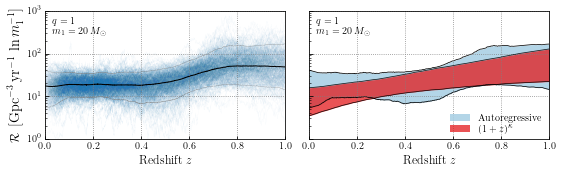

In [7]:
fig = plt.figure(figsize=(8,2.5))

ax = fig.add_subplot(121)
ax.set_rasterization_zorder(2)

p_q1 = (1.+bq)/(1. - (2./20.)**(1.+bq))
R_zs = R_ref[np.newaxis,:]*f_zs*20.*p_q1
      
for i in np.random.choice(range(R_zs.shape[1]),size=500,replace=False):                 
    ax.plot(zs,R_zs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(zs,np.median(R_zs,axis=1),color='black',lw=1,zorder=1)
ax.plot(zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.25,zorder=1)
ax.plot(zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.25,zorder=1)

#ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(1,1e3)
ax.set_yscale('log')

ax.text(0.03,0.84,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax.text(0.03,0.92,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}')
ax.set_xlabel('Redshift $z$')

ax = fig.add_subplot(122)
ax.set_rasterization_zorder(2)
    
ax.plot(zs[::10],np.quantile(R_zs[::10],0.05,axis=1),color='black',lw=0.75,zorder=1)
ax.plot(zs[::10],np.quantile(R_zs[::10],0.95,axis=1),color='black',lw=0.75,zorder=1)
ax.fill_between(zs[::10],
                np.quantile(R_zs[::10],0.05,axis=1),
                np.quantile(R_zs[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=0,lw=0,
                label='Autoregressive')

ax.plot(lvk_z_grid,np.quantile(lvk_R_z,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=3)
ax.plot(lvk_z_grid,np.quantile(lvk_R_z,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=3)
ax.fill_between(lvk_z_grid,
                np.quantile(lvk_R_z,0.05,axis=0),
                np.quantile(lvk_R_z,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0,
                label=r'$(1+z)^\kappa$')

#ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(1,1e3)
ax.set_yscale('log')
ax.set_yticklabels([])

ax.legend(loc=(0.57,0.),fontsize=10,labelspacing=0.2)
ax.text(0.03,0.84,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax.text(0.03,0.92,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax.set_xlabel('Redshift $z$')

plt.tight_layout()
plt.savefig('z.pdf',bbox_inches='tight',dpi=200)
plt.show()

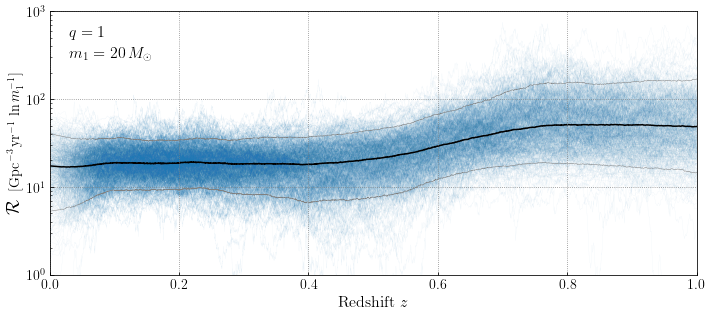

In [41]:
fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

p_q1 = (1.+bq)/(1. - (2./20.)**(1.+bq))
R_zs = R_ref[np.newaxis,:]*f_zs*20.*p_q1
      
for i in np.random.choice(range(R_zs.shape[1]),size=600,replace=False):                 
    ax.plot(zs,R_zs[:,i],color='#1f78b4',alpha=0.1,lw=0.2,zorder=0)

ax.plot(zs,np.median(R_zs,axis=1),color='black',zorder=1)
ax.plot(zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.5,zorder=1)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(1,1e3)
ax.set_yscale('log')

ax.text(0.03,0.84,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=16)
ax.text(0.03,0.92,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=16)
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Redshift $z$',fontsize=16)

plt.tight_layout()
plt.savefig('alt_z.pdf',bbox_inches='tight',dpi=200)
plt.show()

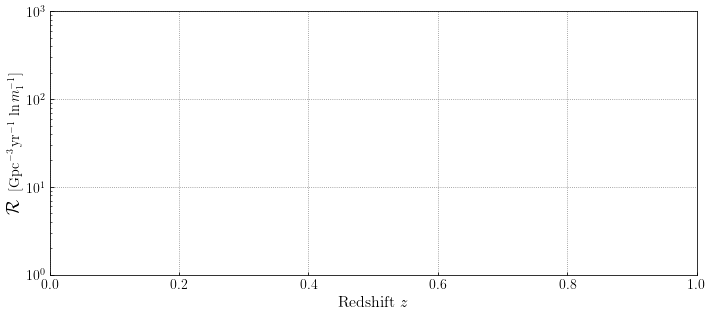

In [22]:
fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(1,1e3)
ax.set_yscale('log')

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Redshift $z$',fontsize=16)

plt.tight_layout()
plt.savefig('alt_z_blank.pdf',bbox_inches='tight',dpi=200)
plt.show()

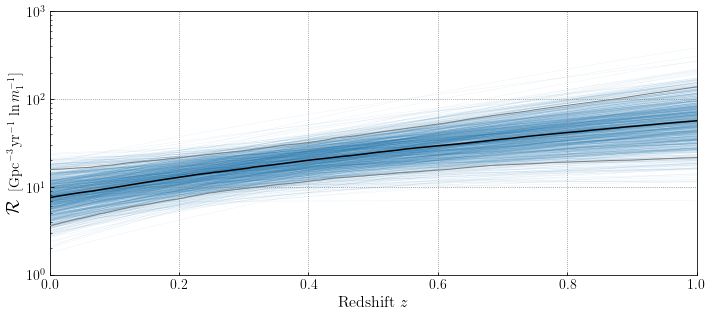

In [39]:
fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

for i in range(1000):
    ax.plot(lvk_z_grid,lvk_R_z[i,:],color='#1f78b4',alpha=0.1,lw=0.4,zorder=0)
    
ax.plot(lvk_z_grid,np.quantile(lvk_R_z,0.05,axis=0),color='grey',lw=1,zorder=3)
ax.plot(lvk_z_grid,np.quantile(lvk_R_z,0.95,axis=0),color='grey',lw=1,zorder=3)
ax.plot(lvk_z_grid,np.median(lvk_R_z,axis=0),color='black',lw=1.5,zorder=3)

ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(1,1e3)
ax.set_yscale('log')

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Redshift $z$',fontsize=16)

plt.tight_layout()
plt.savefig('alt_z_lvk.pdf',bbox_inches='tight',dpi=200)
plt.show()

0.4928888888888889


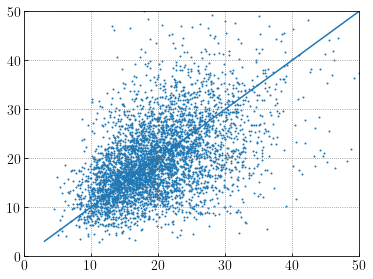

In [19]:
ind_z_01 = np.argmin(np.abs(zs-0.1))
ind_z_02 = np.argmin(np.abs(zs-0.2))
ind_z_03 = np.argmin(np.abs(zs-0.3))
ind_z_04 = np.argmin(np.abs(zs-0.4))

Rs_z_01_to_02 = np.mean(R_zs[ind_z_01:ind_z_02,:],axis=0)
Rs_z_03_to_04 = np.mean(R_zs[ind_z_03:ind_z_04,:],axis=0)

fig,ax = plt.subplots()
ax.scatter(Rs_z_01_to_02,Rs_z_03_to_04,s=1)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.plot([3,100],[3,100])

ax.set_xlim(0,50)
ax.set_ylim(0,50)

ratio = Rs_z_03_to_04/Rs_z_01_to_02
print(ratio[ratio>1].size/ratio.size)

0.9555555555555556


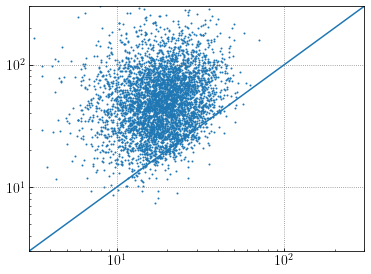

In [20]:
ind_z_03 = np.argmin(np.abs(zs-0.3))
ind_z_04 = np.argmin(np.abs(zs-0.4))
ind_z_07 = np.argmin(np.abs(zs-0.7))
ind_z_08 = np.argmin(np.abs(zs-0.8))

Rs_z_03_to_04 = np.mean(R_zs[ind_z_03:ind_z_04,:],axis=0)
Rs_z_07_to_08 = np.mean(R_zs[ind_z_07:ind_z_08,:],axis=0)

fig,ax = plt.subplots()
ax.scatter(Rs_z_03_to_04,Rs_z_07_to_08,s=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([3,300],[3,300])

ax.set_xlim(3,300)
ax.set_ylim(3,300)

ratio = Rs_z_07_to_08/Rs_z_03_to_04
print(ratio[ratio>1].size/ratio.size)

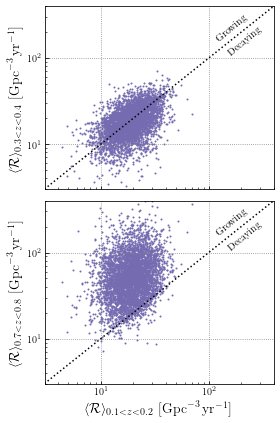

0.48733333333333334
0.9593333333333334


In [69]:
ind_z_01 = np.argmin(np.abs(zs-0.1))
ind_z_02 = np.argmin(np.abs(zs-0.2))
ind_z_03 = np.argmin(np.abs(zs-0.3))
ind_z_04 = np.argmin(np.abs(zs-0.4))
ind_z_07 = np.argmin(np.abs(zs-0.7))
ind_z_08 = np.argmin(np.abs(zs-0.8))

Rs_z_01_to_02 = np.trapz(R_zs[ind_z_01:ind_z_02,:],zs[ind_z_01:ind_z_02],axis=0)/(zs[ind_z_02] - zs[ind_z_01])
Rs_z_03_to_04 = np.trapz(R_zs[ind_z_03:ind_z_04,:],zs[ind_z_03:ind_z_04],axis=0)/(zs[ind_z_04] - zs[ind_z_03])
Rs_z_07_to_08 = np.trapz(R_zs[ind_z_07:ind_z_08,:],zs[ind_z_07:ind_z_08],axis=0)/(zs[ind_z_08] - zs[ind_z_07])

fig = plt.figure(figsize=(4,6))

ax = fig.add_subplot(211)
ax.set_rasterization_zorder(1)
ax.scatter(Rs_z_01_to_02,Rs_z_03_to_04,s=1,color='#756bb1',zorder=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([3,400],[3,400],color='black',ls=':')
ax.set_xlim(3,400)
ax.set_ylim(3,400)
ax.set_xticklabels([])

ax.set_ylabel(r'$\langle \mathcal{R}\rangle_{0.3<z<0.4}\,\,{[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]}$',
             fontsize=14)

ax.text(0.89, 0.8, 'Growing',
        verticalalignment='bottom',
        horizontalalignment='right',
        rotation=40.,
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.text(0.95, 0.72, 'Decaying',
        verticalalignment='bottom',
        horizontalalignment='right',
        rotation=40.,
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax = fig.add_subplot(212)
ax.set_rasterization_zorder(1)
ax.scatter(Rs_z_01_to_02,Rs_z_07_to_08,s=1,color='#756bb1',zorder=0)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot([3,400],[3,400],color='black',ls=':')
ax.set_xlim(3,400)
ax.set_ylim(3,400)

ax.set_xlabel(r'$\langle \mathcal{R}\rangle_{0.1< z < 0.2}\,\,{[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]}$',
             fontsize=14)
ax.set_ylabel(r'$\langle \mathcal{R}\rangle_{0.7< z < 0.8}\,\,{[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]}$',
             fontsize=14)

ax.text(0.89, 0.8, 'Growing',
        verticalalignment='bottom',
        horizontalalignment='right',
        rotation=40.,
        transform=ax.transAxes,
        color='black',
        fontsize=10)

ax.text(0.95, 0.72, 'Decaying',
        verticalalignment='bottom',
        horizontalalignment='right',
        rotation=40.,
        transform=ax.transAxes,
        color='black',
        fontsize=10)

plt.tight_layout()
plt.savefig('rate_growth.pdf',bbox_inches='tight',dpi=200)
plt.show()

ratio_low = Rs_z_03_to_04/Rs_z_01_to_02
ratio_high = Rs_z_07_to_08/Rs_z_01_to_02
print(ratio_low[ratio_low>1].size/ratio_low.size)
print(ratio_high[ratio_high>1].size/ratio_high.size)

In [8]:
def sigmoid(x,x0,dx,r0,r1):
    return r0 + r1/(1.+np.exp(-(x-x0)/dx))

def broken_pl(x,zb,k1,k2,r0):
    return r0*np.where(x<zb,(x/zb)**k1,(x/zb)**k2)
                       
def alt_broken_pl(x,zb,k1,k2,r0):
    return r0*np.where(x<zb,((1.+x)/(1.+zb))**k1,((1.+x)/(1.+zb))**k2)

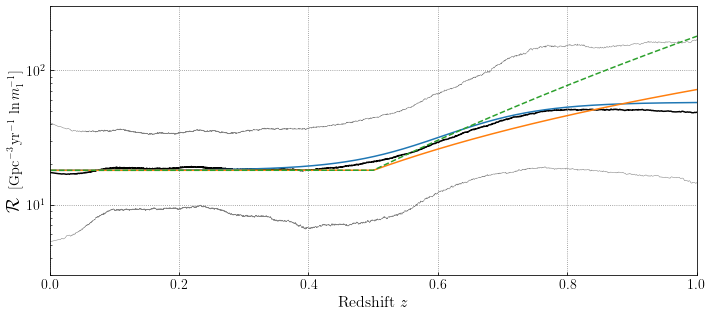

In [9]:
fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

ax.plot(zs,np.median(R_zs,axis=1),color='black',zorder=1)
ax.plot(zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.5,zorder=1)

z0 = 0.65
dz = 0.075
r0 = 18
dr = 40
test = sigmoid(zs,z0,dz,r0,dr)
ax.plot(zs,test)

zb = 0.5
k1 = 0.
k2 = 2.
r0 = 18.
test_bpl = broken_pl(zs,zb,k1,k2,r0)
ax.plot(zs,test_bpl)

zb = 0.5
k1 = 0.
alt_k2 = 8.
r0 = 18.
test_bpl = alt_broken_pl(zs,zb,k1,alt_k2,r0)
ax.plot(zs,test_bpl,ls='--')

ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(0,100)
ax.set_ylim(3,3e2)
ax.set_yscale('log')

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Redshift $z$',fontsize=16)

plt.tight_layout()
plt.show()

In [11]:
from scipy.optimize import minimize

zs_to_fit = zs[zs<0.8]
R_z_target = np.median(R_zs,axis=1)[zs<0.8]

def ls_sigmoid(params):
    
    z0,dz,r0,dr = params
    R_z_model = sigmoid(zs_to_fit,z0,dz,r0,dr)
    
    return np.trapz((np.log(R_z_target)-np.log(R_z_model))**2,zs_to_fit)

def ls_bpl(params):
    
    zb,k1,k2,r0 = params
    R_z_model = broken_pl(zs_to_fit,zb,k1,k2,r0)
    
    return np.trapz((np.log(R_z_target)-np.log(R_z_model))**2,zs_to_fit)

def ls_alt_bpl(params):
    
    zb,k1,k2,r0 = params
    R_z_model = alt_broken_pl(zs_to_fit,zb,k1,k2,r0)
    
    return np.trapz((np.log(R_z_target)-np.log(R_z_model))**2,zs_to_fit)

In [12]:
initial_params_sigmoid = (z0,dz,r0,dr)
sigmoid_soln = minimize(ls_sigmoid,initial_params_sigmoid,method='Nelder-Mead',options={'maxiter':1e4})
sigmoid_soln

 final_simplex: (array([[ 0.65228036,  0.06017874, 18.15793386, 35.67932598],
       [ 0.65228067,  0.06017876, 18.15793485, 35.6793618 ],
       [ 0.65228034,  0.06017867, 18.1579341 , 35.67934585],
       [ 0.65228057,  0.06017871, 18.15793866, 35.67933969],
       [ 0.65228001,  0.06017854, 18.15793567, 35.67925789]]), array([0.00050934, 0.00050934, 0.00050934, 0.00050934, 0.00050934]))
           fun: 0.0005093373984974743
       message: 'Optimization terminated successfully.'
          nfev: 243
           nit: 138
        status: 0
       success: True
             x: array([ 0.65228036,  0.06017874, 18.15793386, 35.67932598])

In [13]:
initial_params_bpl = (zb,k1,k2,r0)
bpl_soln = minimize(ls_bpl,initial_params_bpl,method='Nelder-Mead',options={'maxiter':1e4})
bpl_soln

 final_simplex: (array([[ 0.48541527,  0.02554509,  2.12592154, 18.86842904],
       [ 0.48541506,  0.02554757,  2.12590851, 18.86845362],
       [ 0.48541668,  0.02555001,  2.12594337, 18.86850793],
       [ 0.48541355,  0.02554798,  2.12591978, 18.86840224],
       [ 0.48541412,  0.02554945,  2.12591489, 18.86850564]]), array([0.0005795, 0.0005795, 0.0005795, 0.0005795, 0.0005795]))
           fun: 0.0005794964722037935
       message: 'Optimization terminated successfully.'
          nfev: 276
           nit: 165
        status: 0
       success: True
             x: array([ 0.48541527,  0.02554509,  2.12592154, 18.86842904])

In [14]:
initial_params_alt_bpl = (zb,k1,alt_k2,r0)
alt_bpl_soln = minimize(ls_alt_bpl,initial_params_alt_bpl,method='Nelder-Mead',options={'maxiter':1e4})
alt_bpl_soln

 final_simplex: (array([[ 0.47698731,  0.16904458,  5.45943913, 18.9451951 ],
       [ 0.47698998,  0.16906246,  5.45953261, 18.94521609],
       [ 0.47698539,  0.16904731,  5.45943012, 18.94510938],
       [ 0.47698721,  0.16905185,  5.45942715, 18.94517748],
       [ 0.47698774,  0.1690628 ,  5.4594332 , 18.94524866]]), array([0.00068106, 0.00068106, 0.00068106, 0.00068106, 0.00068106]))
           fun: 0.0006810638372278101
       message: 'Optimization terminated successfully.'
          nfev: 325
           nit: 186
        status: 0
       success: True
             x: array([ 0.47698731,  0.16904458,  5.45943913, 18.9451951 ])

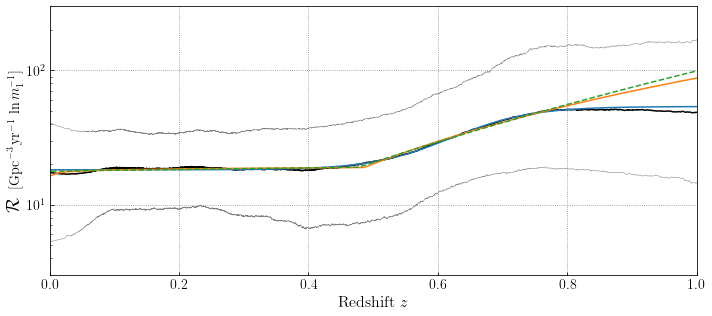

In [15]:
fig = plt.figure(figsize=(10,4.5))

ax = fig.add_subplot(111)
ax.set_rasterization_zorder(2)

ax.plot(zs,np.median(R_zs,axis=1),color='black',zorder=1)
ax.plot(zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.5,zorder=1)
ax.plot(zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.5,zorder=1)

test = sigmoid(zs,*sigmoid_soln.x)
ax.plot(zs,test)

test_bpl = broken_pl(zs,*bpl_soln.x)
ax.plot(zs,test_bpl)

test_alt_bpl = alt_broken_pl(zs,*alt_bpl_soln.x)
ax.plot(zs,test_alt_bpl,ls='--')

ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(0,100)
ax.set_ylim(3,3e2)
ax.set_yscale('log')

ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}',fontsize=18)
ax.set_xlabel('Redshift $z$',fontsize=16)

plt.tight_layout()
plt.show()

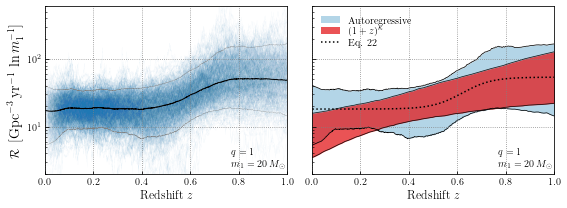

In [48]:
fig = plt.figure(figsize=(8,3))

ax = fig.add_subplot(121)
ax.set_rasterization_zorder(2)

p_q1 = (1.+bq)/(1. - (2./20.)**(1.+bq))
R_zs = R_ref[np.newaxis,:]*f_zs*20.*p_q1
      
for i in np.random.choice(range(R_zs.shape[1]),size=500,replace=False):                 
    ax.plot(zs,R_zs[:,i],color='#1f78b4',alpha=0.1,lw=0.1,zorder=0)

ax.plot(zs,np.median(R_zs,axis=1),color='black',lw=1,zorder=1)
ax.plot(zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.25,zorder=1)
ax.plot(zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.25,zorder=1)

#ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(2,6e2)
ax.set_yscale('log')

ax.text(0.77,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax.text(0.77,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax.set_ylabel(r'$\mathcal{R}$ \,{\Large[$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]}')
ax.set_xlabel('Redshift $z$')

ax = fig.add_subplot(122)
ax.set_rasterization_zorder(2)
    
ax.plot(zs[::10],np.quantile(R_zs[::10],0.05,axis=1),color='black',lw=0.75,zorder=1)
ax.plot(zs[::10],np.quantile(R_zs[::10],0.95,axis=1),color='black',lw=0.75,zorder=1)
ax.fill_between(zs[::10],
                np.quantile(R_zs[::10],0.05,axis=1),
                np.quantile(R_zs[::10],0.95,axis=1),
                color='#a6cee3',alpha=0.85,zorder=0,lw=0,
                label='Autoregressive')

ax.plot(lvk_z_grid,np.quantile(lvk_R_z,0.05,axis=0),color='black',lw=0.75,alpha=0.9,zorder=3)
ax.plot(lvk_z_grid,np.quantile(lvk_R_z,0.95,axis=0),color='black',lw=0.75,alpha=0.9,zorder=3)
ax.fill_between(lvk_z_grid,
                np.quantile(lvk_R_z,0.05,axis=0),
                np.quantile(lvk_R_z,0.95,axis=0),
                color='#e31a1c',alpha=0.75,zorder=0,lw=0,
                label=r'$(1+z)^\kappa$')

sigmoid_fit = sigmoid(zs,*sigmoid_soln.x)
ax.plot(zs,sigmoid_fit,color='black',ls=':',lw=1.5,label='Eq. 22')

#bpl_fit = alt_broken_pl(zs,*alt_bpl_soln.x)
#ax.plot(zs,bpl_fit,color='black',dashes=(3,2,1,2),lw=1.)

#ax.tick_params(labelsize=14)
ax.set_xlim(0,1.)
ax.set_ylim(2,6e2)
ax.set_yscale('log')
ax.set_yticklabels([])

#ax.legend(loc=(0.59,0.),fontsize=10,labelspacing=0.2,handlelength=1.9)
#ax.text(0.03,0.84,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
#ax.text(0.03,0.92,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax.legend(loc=(0.02,0.73),fontsize=10,labelspacing=0.2,handlelength=1.9)
ax.text(0.77,0.06,r'$m_1=20\,M_\odot$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax.text(0.77,0.13,r'$q=1$',horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize=10)
ax.set_xlabel('Redshift $z$')

plt.tight_layout()
plt.savefig('z.pdf',bbox_inches='tight',dpi=200)
plt.show()